# Load Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# /content/drive/MyDrive/LeWagon/models

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/LeWagon/data/dataset_balanced_big.zip 

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: dataset_balanced_big/train/rain/2021_05_13_0950_01_m.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_0950_02.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_0950_02_f.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_0950_02_m.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1045_01_f.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1045_01_m.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1045_02_f.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1100_01.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1100_01_f.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1100_01_m.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1100_02.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1100_02_f.jpg  
  inflating: dataset_balanced_big/train/rain/2021_05_13_1100_02_m.jpg  
  i

# VGG16

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 200, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    pred = layers.Dense(1, activation = "sigmoid")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


Found 14924 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Train/test/validation data loaded
58889256/58889256 [==============================] - 0s 0us/step
Model initialised
Model compiled
Epoch 1/40
234/234 [==============================] - 121s 469ms/step - loss: 0.5483 - accuracy: 0.7050 - val_loss: 0.4512 - val_accuracy: 0.8055 - lr: 0.0010
Epoch 2/40
234/234 [==============================] - 110s 469ms/step - loss: 0.4901 - accuracy: 0.7588 - val_loss: 0.4580 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 3/40
234/234 [==============================] - 108s 462ms/step - loss: 0.4806 - accuracy: 0.7658 - val_loss: 0.4301 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 4/40
234/234 [==============================] - 110s 470ms/step - loss: 0.4664 - accuracy: 0.7782 - val_loss: 0.4253 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 5/40
234/234 [==============================] - 108s 460ms/step - loss: 0.4456 - accuracy: 0.7932 -

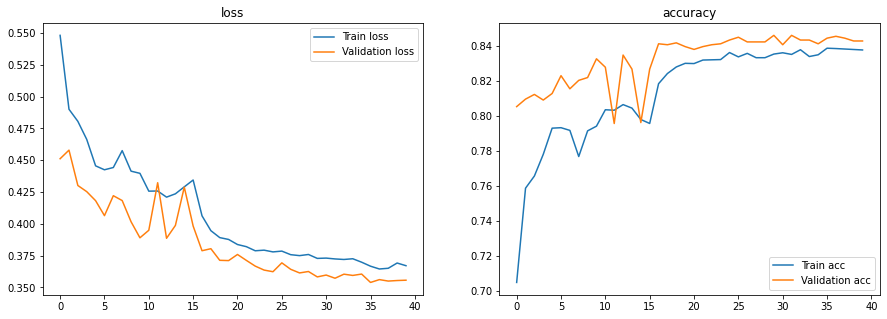

In [ ]:
lr=0.001
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=64
epochs=40

tr="/content/dataset_balanced_big/train"
te="/content/dataset_balanced_big/test"
v="/content/dataset_balanced_big/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)
#model=ld_model(filename)
#model.summary()

Epoch 1/20
234/234 [==============================] - 107s 457ms/step - loss: 0.3653 - accuracy: 0.8403 - val_loss: 0.3556 - val_accuracy: 0.8446 - lr: 1.0000e-06
Epoch 2/20
234/234 [==============================] - 108s 460ms/step - loss: 0.3642 - accuracy: 0.8405 - val_loss: 0.3555 - val_accuracy: 0.8441 - lr: 1.0000e-06
Epoch 3/20
234/234 [==============================] - 108s 461ms/step - loss: 0.3651 - accuracy: 0.8393 - val_loss: 0.3555 - val_accuracy: 0.8446 - lr: 1.0000e-06
Epoch 4/20
234/234 [==============================] - 106s 454ms/step - loss: 0.3658 - accuracy: 0.8380 - val_loss: 0.3553 - val_accuracy: 0.8435 - lr: 1.0000e-06
Epoch 5/20
234/234 [==============================] - 106s 455ms/step - loss: 0.3630 - accuracy: 0.8411 - val_loss: 0.3553 - val_accuracy: 0.8446 - lr: 1.0000e-06
Epoch 6/20
234/234 [==============================] - 107s 456ms/step - loss: 0.3648 - accuracy: 0.8392 - val_loss: 0.3554 - val_accuracy: 0.8457 - lr: 1.0000e-06
Epoch 7/20
234/234 [==

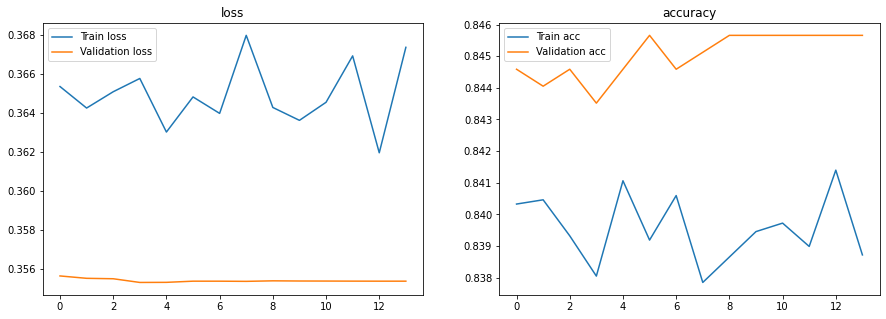

In [ ]:
epochs=20

(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)
#model=ld_model(filename)
#model.summary()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(255, 340),
        batch_size=batch_size,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(255, 340),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(255, 340),
        batch_size=batch_size,
        class_mode='binary')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (255, 340, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    pred = layers.Dense(1, activation = "sigmoid")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


Found 14924 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Train/test/validation data loaded
Model initialised
Model compiled
Epoch 1/40
234/234 [==============================] - 171s 687ms/step - loss: 0.6028 - accuracy: 0.6599 - val_loss: 0.4805 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 2/40
234/234 [==============================] - 158s 674ms/step - loss: 0.5235 - accuracy: 0.7293 - val_loss: 0.4894 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 3/40
234/234 [==============================] - 159s 680ms/step - loss: 0.5101 - accuracy: 0.7363 - val_loss: 0.4668 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 4/40
234/234 [==============================] - 157s 671ms/step - loss: 0.5209 - accuracy: 0.7269 - val_loss: 0.4929 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 5/40
234/234 [==============================] - 158s 676ms/step - loss: 0.5007 - accuracy: 0.7460 - val_loss: 0.4632 - val_accuracy: 0.7878 - lr: 0.0010
Epoch 6/40


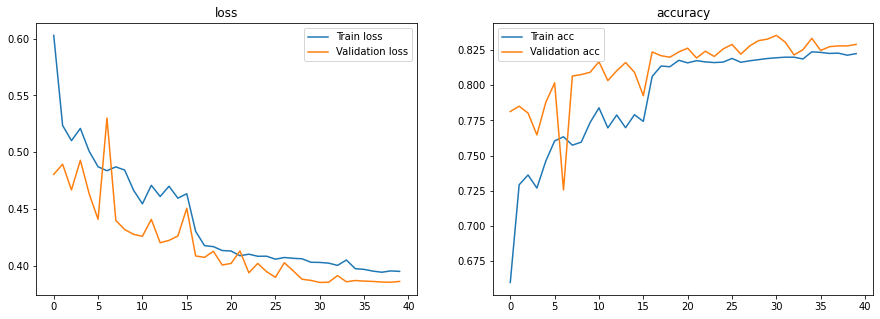

In [ ]:
lr=0.001
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=64
epochs=40

tr="/content/dataset_balanced_big/train"
te="/content/dataset_balanced_big/test"
v="/content/dataset_balanced_big/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 200, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    pred = layers.Dense(1, activation = "sigmoid")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


Found 14924 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Train/test/validation data loaded
Model initialised
Model compiled
Epoch 1/40
117/117 [==============================] - 124s 994ms/step - loss: 0.5786 - accuracy: 0.6809 - val_loss: 0.4835 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 2/40
117/117 [==============================] - 109s 933ms/step - loss: 0.4757 - accuracy: 0.7762 - val_loss: 0.4446 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/40
117/117 [==============================] - 109s 932ms/step - loss: 0.4701 - accuracy: 0.7784 - val_loss: 0.4237 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 4/40
117/117 [==============================] - 110s 939ms/step - loss: 0.4448 - accuracy: 0.7961 - val_loss: 0.4195 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 5/40
117/117 [==============================] - 110s 940ms/step - loss: 0.4583 - accuracy: 0.7808 - val_loss: 0.4418 - val_accuracy: 0.7899 - lr: 0.0010
Epoch 6/40


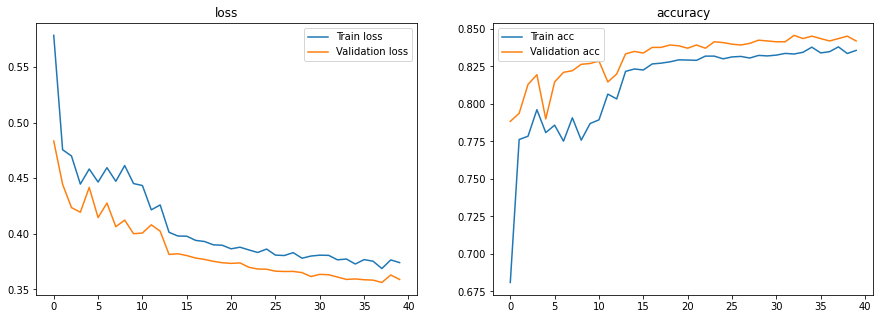

In [ ]:
lr=0.001
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=128
epochs=40

tr="/content/dataset_balanced_big/train"
te="/content/dataset_balanced_big/test"
v="/content/dataset_balanced_big/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)

# VGG19

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='binary')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = VGG19(weights = "imagenet", include_top = False, input_shape = (150, 200, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    pred = layers.Dense(1, activation = "sigmoid")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


In [ ]:
lr=0.001
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=64
epochs=40

tr="/content/dataset_balanced_big/train"
te="/content/dataset_balanced_big/test"
v="/content/dataset_balanced_big/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)

# ResNet50

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = ResNet50V2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation = "relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.4)(x)
    pred = layers.Dense(1, activation = "sigmoid")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


In [ ]:
lr=0.01
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=64
epochs=40

tr="/content/dataset_balanced_big/train"
te="/content/dataset_balanced_big/test"
v="/content/dataset_balanced_big/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)

Found 14924 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Found 1866 images belonging to 2 classes.
Train/test/validation data loaded
Model initialised
Model compiled
Epoch 1/40
234/234 [==============================] - 117s 487ms/step - loss: 1.6803 - accuracy: 0.7534 - val_loss: 0.4136 - val_accuracy: 0.8049 - lr: 0.0100
Epoch 2/40
234/234 [==============================] - 115s 493ms/step - loss: 0.4453 - accuracy: 0.8031 - val_loss: 0.3644 - val_accuracy: 0.8167 - lr: 0.0100
Epoch 3/40
234/234 [==============================] - 111s 474ms/step - loss: 0.4081 - accuracy: 0.8170 - val_loss: 0.3688 - val_accuracy: 0.8092 - lr: 0.0100
Epoch 4/40
234/234 [==============================] - 111s 474ms/step - loss: 0.4069 - accuracy: 0.8125 - val_loss: 0.3603 - val_accuracy: 0.8049 - lr: 0.0100
Epoch 5/40
234/234 [==============================] - 108s 460ms/step - loss: 0.3939 - accuracy: 0.8161 - val_loss: 0.4500 - val_accuracy: 0.7406 - lr: 0.0100
Epoch 6/40
